## 决策树分类器

In [1]:
from numpy import *
from scipy import *
from math import log
import operator
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
#划分数据集
def load_data(ratio):
    data = pd.read_csv("new_D1.csv",header=None)
    data_set = np.array(data).tolist()
    train_data, test_data = train_test_split(data_set,test_size = ratio)
    return train_data,test_data
 

#决策树的生成
def generate_decision_tree(data_set ,attribute_label):
    label_list = [entry[-1] for entry in data_set]
    if label_list.count(label_list[0]) == len(label_list): #如果所有的数据都属于同一个类别，则返回该类别
        return label_list[0]
    if len(data_set[0]) == 1: #如果数据没有属性值数据，则返回该其中出现最多的类别作为分类
        return most_voted_attribute(label_list)
    best_attribute_index, best_split_point = attribute_selection_method(data_set)
    best_attribute = attribute_label[best_attribute_index]
    decision_tree = { best_attribute:{}}
    del(attribute_label[best_attribute_index]) #找到最佳划分属性后需要将其从属性名列表中删除

    #如果best_split_point为空，说明此时最佳划分属性的类型为离散值，否则为连续值
    if best_split_point == None:
        attribute_list = [entry[best_attribute_index] for entry in data_set]
        attribute_set = set(attribute_list)
        for attribute in attribute_set: #属性的各个值
            sub_labels = attribute_label[:]
            decision_tree[best_attribute][attribute] = generate_decision_tree(
                split_data_set(data_set,best_attribute_index,attribute,continuous=False),sub_labels)
    else:
        #最佳划分属性类型为连续值，此时计算出的最佳划分点将数据集一分为二，划分字段取名为<=和>
        sub_labels = attribute_label[:]
        decision_tree[best_attribute]["<="+str(best_split_point)] = generate_decision_tree(
            split_data_set(data_set, best_attribute_index, best_split_point, True, 0), sub_labels)
        sub_labels = attribute_label[:]
        decision_tree[best_attribute][">" + str(best_split_point)] = generate_decision_tree(
            split_data_set(data_set, best_attribute_index, best_split_point, True, 1), sub_labels)
    return decision_tree
 
#通过信息增益比来计算最佳划分属性
def attribute_selection_method(data_set):
    num_attributes = len(data_set[0])-1 #属性的个数，减1是因为去掉了标签
    info_D = calc_info_D(data_set)  #香农熵
    max_grian_rate = 0.0  #最大信息增益比
    best_attribute_index = -1
    best_split_point = None
    continuous = False
    for i in range(num_attributes):
        attribute_list = [entry[i] for entry in data_set]  # 求属性列表，此时为连续值
        info_A_D = 0.0  #特征A对数据集D的信息增益
        split_info_D = 0.0  #数据集D关于特征A的值的熵
        if attribute_list[0] not in set(['M','F','I']):
            continuous = True
        """
        属性为连续值，先对该属性下的所有离散值进行排序
        然后每相邻的两个值之间的中点作为划分点计算信息增益比，对应最大增益比的划分点为最佳划分点
        由于可能多个连续值可能相同，所以通过set只保留其中一个值
        """
        if continuous == True:
            attribute_list = sort(attribute_list)
            temp_set = set(attribute_list) #通过set来剔除相同的值
            attribute_list = [attr for attr in temp_set]
            split_points = []
            for index in range(len(attribute_list) - 1):
                #求出各个划分点
                split_points.append((float(attribute_list[index]) + float(attribute_list[index + 1])) / 2)
            for split_point in split_points:#对划分点进行遍历
                info_A_D = 0.0
                split_info_D = 0.0
                for part in range(2): #最佳划分点将数据一分为二，因此循环2次即可得到两段数据
                    sub_data_set = split_data_set(data_set, i, split_point, True, part)
                    prob = len(sub_data_set) / float(len(data_set))
                    info_A_D += prob * calc_info_D(sub_data_set)
                    split_info_D -= prob * log(prob, 2)
                if split_info_D==0:
                    split_info_D+=1
                
                #由于关于属性A的熵split_info_D可能为0，因此此处加1
                
                grian_rate = (info_D - info_A_D) / split_info_D #计算信息增益比
                if grian_rate > max_grian_rate:
                    max_grian_rate = grian_rate
                    best_split_point = split_point
                    best_attribute_index = i
                    #print([best_attribute_index,best_split_point])
        else: #划分属性为离散值
            attribute_list = [entry[i] for entry in data_set]  # 求属性列表
            attribute_set = set(attribute_list)
            for attribute in attribute_set: #对每个属性进行遍历
                sub_data_set = split_data_set(data_set, i, attribute, False)
                prob = len(sub_data_set) / float(len(data_set))
                info_A_D += prob * calc_info_D(sub_data_set)
                split_info_D -= prob * log(prob, 2)
            if split_info_D == 0:
                split_info_D += 1
            grian_rate = (info_D - info_A_D) / split_info_D #计算信息增益比
            if grian_rate > max_grian_rate:
                max_grian_rate = grian_rate
                # print(max_grian_rate)
                best_attribute_index = i
                best_split_point = None  #如果最佳属性是离散值，此处将分割点置为空留作判定
 
    return best_attribute_index,best_split_point
 
#多数表决：返回标签列表中数量最大的类
def most_voted_attribute(label_list):
    label_nums = {}
    for label in label_list:
        if label in label_nums.keys():
            label_nums[label] += 1
        else:
            label_nums[label] = 1
    sorted_label_nums = sorted(label_nums.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_label_nums[0][0]
 
#计算信息熵
def calc_info_D(data_set):
    num_entries = len(data_set)
    label_nums = {} #为每个类别建立字典，value为对应该类别的数目
    for entry in data_set:
        label = entry[-1]
        if label in label_nums.keys():
            label_nums[label]+=1
        else:
            label_nums[label]=1
    info_D = 0.0
    for label in label_nums.keys():
        prob = float(label_nums[label])/num_entries
        info_D -= prob * log(prob,2)
    return info_D
 

#按属性划分子数据集，分为离散属性的划分与连续属性的划分
def split_data_set(data_set, index, value, continuous, part=0):
    res_data_set = []
    if continuous == True:#划分的属性为连续值
        for entry in data_set:
            if part == 0 and float(entry[index])<= value: #求划分点左侧的数据集
                reduced_entry = entry[:index]
                reduced_entry.extend(entry[index + 1:]) #划分后去除数据中第index列的值
                res_data_set.append(reduced_entry)
            if part ==1 and float(entry[index])> value: #求划分点右侧的数据集
                reduced_entry = entry[:index]
                reduced_entry.extend(entry[index + 1:])
                res_data_set.append(reduced_entry)
 
    else: #划分的属性为离散值
        for entry in data_set:
            if entry[index] == value: #按数据集中第index列的值等于value的分数据集
                reduced_entry = entry[:index]
                reduced_entry.extend(entry[index+1:]) #划分后去除数据中第index列的值
                res_data_set.append(reduced_entry)
    return res_data_set
 

#对一项测试数据进行预测，通过递归来预测该项数据的标签
def decision_tree_predict(decision_tree, attribute_labels, one_test_data):
    first_key = list(decision_tree.keys())[0]
    second_dic = decision_tree[first_key]
    attribute_index = attribute_labels.index(first_key)
    res_label = None
    for key in second_dic.keys(): #属性分连续值和离散值，连续值对应<=和>两种情况
        if key[0] == '<':
            value = float(key[2:])
            if float(one_test_data[attribute_index])<= value:
                if type(second_dic[key]).__name__ =='dict':
                    res_label = decision_tree_predict(second_dic[key], attribute_labels, one_test_data)
                else:
                    res_label = second_dic[key]
        elif key[0] == '>':
            #print(key[1:])
            value = float(key[1:])
            if float(one_test_data[attribute_index]) > value:
                if type(second_dic[key]).__name__ == 'dict':
                    res_label = decision_tree_predict(second_dic[key], attribute_labels, one_test_data)
                else:
                    res_label = second_dic[key]
 
        else:
            if one_test_data[attribute_index] == key:
                if type(second_dic[key]).__name__ =='dict':
                    res_label = decision_tree_predict(second_dic[key], attribute_labels, one_test_data)
                else:
                    res_label = second_dic[key]
    return res_label
 
if __name__ == '__main__':
    ratio = 0.3 #测试集的比例
    train_data, test_data =load_data(ratio)
    attribute_label = ['Sex','Length','Diameter','Height','Whole_Weight','Shcked_Weight','Viscera_Weight','Shell_Weight']
    decision_tree= generate_decision_tree(train_data,attribute_label)
    #递归会改变attribute_label的值，此处再传一次
    attribute_label = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_Weight', 'Shcked_Weight', 'Viscera_Weight',
                       'Shell_Weight']
    count = 0
    y_predict_list = []
    y_test_list = []
    #预测，计算准确率并输出混淆矩阵
    for one_test_data in test_data:
        y_predict = decision_tree_predict(decision_tree,attribute_label,one_test_data)
        y_test = one_test_data[-1]
        y_predict_list.append(y_predict)
        y_test_list.append(y_test)
        if  y_predict == y_test:
            count+=1
    accuracy = count/len(test_data)
    precision_macro1 = metrics.precision_score(y_test_list, y_predict_list, average='macro')
    precision_micro1 = metrics.precision_score(y_test_list, y_predict_list, average='micro')
    recall_macro1 = metrics.recall_score(y_test_list, y_predict_list, average='macro')
    recall_micro1 = metrics.recall_score(y_test_list, y_predict_list, average='micro')
    F1_measure_macro1 = metrics.f1_score(y_test_list, y_predict_list, average='macro')
    F1_measure_micro1 = metrics.f1_score(y_test_list, y_predict_list, average='micro')
    cm1 = confusion_matrix(y_test_list, y_predict_list)
    print('决策树分类器的准确率为:', accuracy)
    print('决策树分类器的宏平均精确率为:', precision_macro1)
    print('决策树分类器的微平均精确率为:', precision_micro1)
    print('决策树分类器的宏平均召回率为:', recall_macro1)
    print('决策树分类器的微平均召回率为:', recall_micro1)
    print('决策树分类器的宏平均F1-score为:', F1_measure_macro1)
    print('决策树分类器的微平均F1-score为:', F1_measure_micro1)
    print("混淆矩阵为:\n",cm1)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: scipy.sort is deprecated and will be removed in SciPy 2.0.0, use numpy.sort instead


决策树分类器的准确率为: 0.8676236044657097
决策树分类器的宏平均精确率为: 0.5633099318084598
决策树分类器的微平均精确率为: 0.8676236044657097
决策树分类器的宏平均召回率为: 0.5457043723900762
决策树分类器的微平均召回率为: 0.8676236044657097
决策树分类器的宏平均F1-score为: 0.5523738175861278
决策树分类器的微平均F1-score为: 0.8676236044657096
混淆矩阵为:
 [[189   1  86]
 [  0   0  34]
 [ 45   0 899]]


## 朴素贝叶斯分类器

In [ ]:
import pandas as pd
import numpy as np
import random
import math
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#划分数据集
def load_data(ratio):
    data = pd.read_csv("new_D1.csv",header=None)
    data_set = np.array(data).tolist()
    train_data, test_data = train_test_split(data_set,test_size = ratio)
    return train_data,test_data

#将数据集按照不同的类别划分
def seprateByClass(dataset):
    seprate_dict = {}
    info_dict = {}
    for vector in dataset:
        if vector[-1] not in seprate_dict:
            seprate_dict[vector[-1]] = []
            info_dict[vector[-1]] = 0
        seprate_dict[vector[-1]].append(vector)
        info_dict[vector[-1]] +=1
    return seprate_dict,info_dict

#定义计算均值和方差的方法
def mean(list):
    list = [float(x) for x in list] #字符串转数字
    return sum(list)/float(len(list))
def var(list):
    list = [float(x) for x in list]
    avg = mean(list)
    var = sum([math.pow((x-avg),2) for x in list])/float(len(list)-1)
    return var

#计算每个连续属性的均值和方差
def summarizeAttribute(dataset):
    dataset = np.delete(dataset,-1,axis = 1) # 删除标签
    dataset = np.delete(dataset,0,axis = 1) # 删除离散属性
    summaries = [(mean(attr),var(attr)) for attr in zip(*dataset)]
    return summaries

def summarizeByClass(dataset):
    dataset_separated,dataset_info = seprateByClass(dataset)
    summarize_by_class = {}
    for classValue, vector in dataset_separated.items():
        summarize_by_class[classValue] = summarizeAttribute(vector)
    return summarize_by_class

#计算类条件概率
def calulateClassPriorProb(dataset,dataset_info):
    dataset_prior_prob = {}
    sample_sum = len(dataset)
    for class_value, sample_nums in dataset_info.items():
        dataset_prior_prob[class_value] = sample_nums/float(sample_sum)
    return dataset_prior_prob

#计算离散值的条件概率
def calculateProb(x,mean,var):
    exponent = math.exp(math.pow((x-mean),2)/(-2*var))
    p = (1/math.sqrt(2*math.pi*var))*exponent
    return p

#计算离散值的条件概率
def calculateProb1(dataset):
    train_separated,train_info = seprateByClass(dataset)
    class_keys_list = list(train_info.keys())
    class_values_list = list(train_info.values())
    attri_list = []
    p_list = []
    for i in range(len(class_keys_list)):
        for item in train_separated[class_keys_list[i]]:
            attri_list.append(item[0])
        attri_list = list(Counter(attri_list).values())
        result = 1
        for j in range(len(attri_list)):
            p = attri_list[j] / class_values_list[i]
            result *= p
        p_list.append(result)
    return p_list

#类条件概率
def calculateClassProb(dataset,input_data,train_Summary_by_class):
    prob = {}
    p_list = calculateProb1(dataset)
    a = 0
    for class_value, summary in train_Summary_by_class.items():
        prob[class_value] = p_list[a]
        a += 1
        for i in range(len(summary)):
            mean,var = summary[i]
            x = input_data[i]
            p = calculateProb(x,mean,var)
        prob[class_value] *=p
    return prob

#对单个样本做预测
def bayesianPredictOneSample(dataset, input_data):
    prior_prob = calulateClassPriorProb(trainset,train_info)
    train_Summary_by_class = summarizeByClass(trainset)
    classprob_dict = calculateClassProb(dataset, input_data,train_Summary_by_class)
    result = {}
    for class_value,class_prob in classprob_dict.items():
        p = class_prob*prior_prob[class_value]
        result[class_value] = p
    return max(result,key=result.get)

#对测试集进行预测，并计算准确率
def calculateAccByBeyesian(trainset, dataset):
    correct = 0
    predict_list = []
    for vector in dataset:
        input_data = vector[1:-1]
        label = vector[-1]
        result = bayesianPredictOneSample(trainset,input_data)
        predict_list.append(result)
        if result == label:
            correct+=1
    return predict_list,correct/len(dataset)

if __name__ == '__main__':
    ratio = 0.3 #测试集的比例
    trainset, testset =load_data(ratio)
    train_separated,train_info = seprateByClass(trainset)
    y_pre,acc = calculateAccByBeyesian(trainset, testset)
    y_test = []
    for item in testset:
        y_test.append(item[-1])
    cm2 = confusion_matrix(y_test, y_pre)
    precision_macro2 = metrics.precision_score(y_test, y_pre, average='macro')
    precision_micro2 = metrics.precision_score(y_test, y_pre, average='micro')
    recall_macro2 = metrics.recall_score(y_test, y_pre, average='macro')
    recall_micro2 = metrics.recall_score(y_test, y_pre, average='micro')
    F1_measure_macro2 = metrics.f1_score(y_test, y_pre, average='macro')
    F1_measure_micro2 = metrics.f1_score(y_test, y_pre, average='micro')
    print('朴素贝叶斯分类器的准确率为:', acc)
    print('朴素贝叶斯分类器的宏平均精确率为:', precision_macro2)
    print('朴素贝叶斯分类器的微平均精确率为:', precision_micro2)
    print('朴素贝叶斯分类器的宏平均召回率为:', recall_macro2)
    print('朴素贝叶斯分类器的微平均召回率为:', recall_micro2)
    print('朴素贝叶斯分类器的宏平均F1-score为:', F1_measure_macro2)
    print('朴素贝叶斯分类器的微平均F1-score为:', F1_measure_micro2)
    print("混淆矩阵为:\n",cm2)

## 性能比较

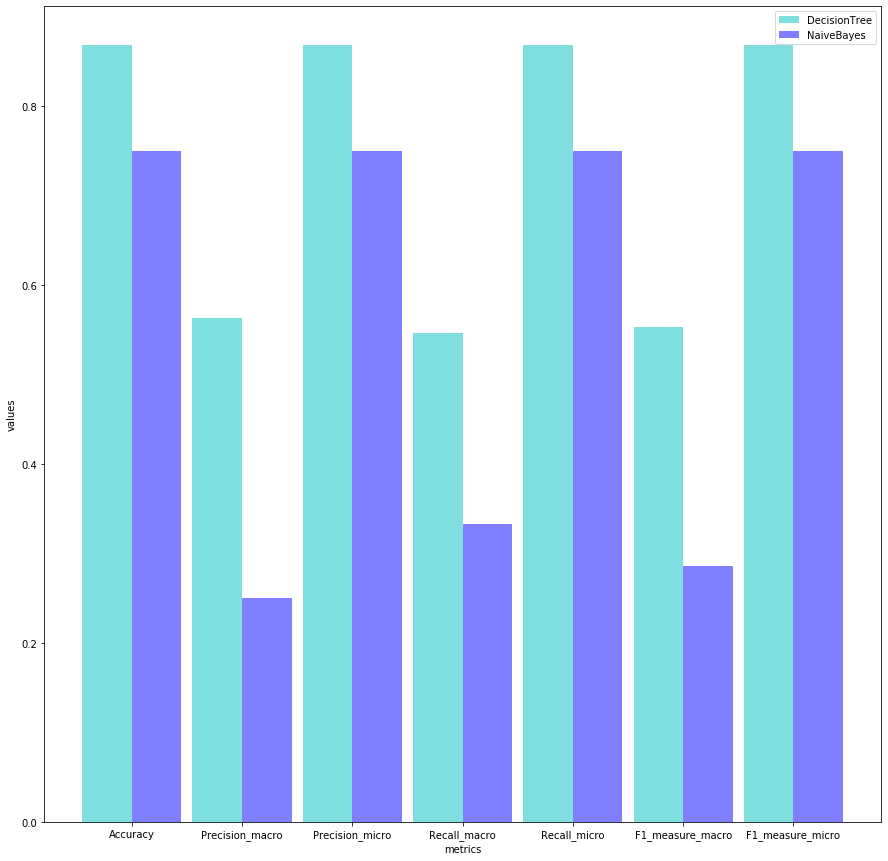

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 15))
x = np.arange(7)
y1 = [accuracy, precision_macro1, precision_micro1, recall_macro1, recall_micro1, F1_measure_macro1, F1_measure_micro1]
y2 = [acc, precision_macro2, precision_micro2, recall_macro2, recall_micro2, F1_measure_macro2, F1_measure_micro2]

bar_width = 0.45
tick_label = ["Accuracy", "Precision_macro", "Precision_micro", "Recall_macro", "Recall_micro", "F1_measure_macro", "F1_measure_micro"]

plt.bar(x, y1, bar_width, align="center", color="c", label="DecisionTree", alpha=0.5)
plt.bar(x+bar_width, y2, bar_width, color="b", align="center", label="NaiveBayes", alpha=0.5)

plt.xlabel("metrics")
plt.ylabel("values")

plt.xticks(x+bar_width/2, tick_label)

plt.legend()
plt.savefig('./D1_DT_NB.svg')
plt.show()